In [1]:
import pandas as pd
import numpy as np
import os
import sys
from skforecast.ForecasterAutoreg import ForecasterAutoreg  ## fare riferimento alla documentazione di skforecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import time
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from skforecast.model_selection import grid_search_forecaster
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### COSTANTI

In [2]:
DATE_LIMITER = "2023-08-01 00:00:00"
TRAIN_SET_PERC = 0.8
LAGS = [96, 192, 288, 384, 480] # 1,2,3,4,5 giorni
STEPS = 4 # 1h

### FUNZIONI

In [3]:
def predict(setToPredict ,lags, steps):
    i=0
    lenVal = len(setToPredict)
    newPreds = []
    newTimes = []
    while(i + lags < lenVal):
        print(f"step {i+1}/{lenVal - lags}", end="\r")
        batch = setToPredict.iloc[i:i + lags]["Value"]
        betterPred = model.predict(steps , last_window=batch)
        newPreds.append(betterPred.iloc[-1])
        newTimes.append(betterPred.index[-1])
        i += 1
    pred = pd.Series(newPreds, newTimes)
    print("\n")
    return pred

In [4]:
def printScore(realData, predictedData):
    mape = mean_absolute_percentage_error(realData, predictedData)
    r2 = r2_score(realData, predictedData)
    print("___SCORE___")
    print(f"mape: {mape}")
    print(f"r2: {r2}")

### DATI

In [5]:
PATH = os.path.dirname(os.path.abspath("__file__"))
PATH = os.path.join(PATH, "data", "trendLvSolignanoUlia.csv")

allData = pd.read_csv(PATH,delimiter=";")
allData.columns = ["Time", "Value"]
allData["Time"] = pd.to_datetime(allData["Time"])
allData.set_index("Time", inplace=True)
allData = allData.resample(rule="15T").mean().ffill()

In [6]:
stableData = allData[allData.index < DATE_LIMITER]

setDivisor = int(len(stableData) * TRAIN_SET_PERC)

trainingSet = stableData.iloc[:setDivisor]
validationSet = stableData.iloc[setDivisor:]


In [7]:
strangeData = allData[allData.index >= DATE_LIMITER]

#### DIVISIONE DI 30 MINUTI

In [8]:
allDataHalfH = allData.resample(rule="30T").mean().ffill()

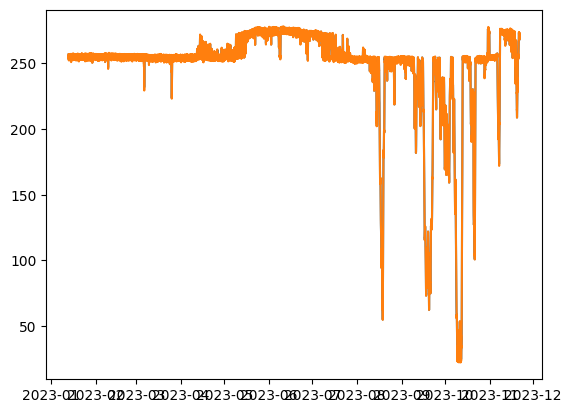

In [9]:
plt.plot(allDataHalfH)
plt.plot(allData)

### TRAINING

In [10]:
xgb = XGBRegressor()
lags = LAGS[0]

model = ForecasterAutoreg(regressor=xgb, lags=lags)

model.fit(trainingSet["Value"])


step 15251/15251

predizione sul Training set: 48 s
___SCORE___
mape: 0.001968701606953373
r2: 0.9930117564092135


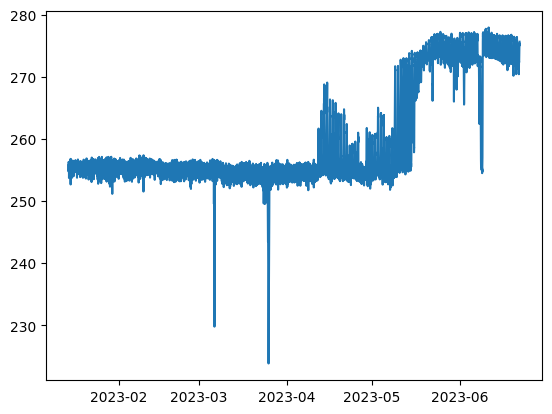

In [11]:
start = time.time()
predVal = predict(trainingSet, lags, STEPS)
plt.plot(predVal, label="predizione Training set")
end = time.time()
print(f"predizione sul Training set: {int(end-start)} s")
printScore(allData.loc[predVal.index].values, predVal.values)

step 3741/3741

predizione sul validation set: 11 s
___SCORE___
mape: 0.0052383058596903774
r2: 0.9444069765579979


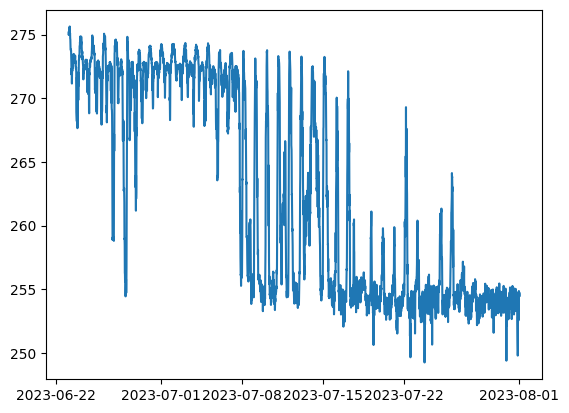

In [12]:
start = time.time()
predVal = predict(validationSet, lags, STEPS)
plt.plot(predVal, label="predizione Validation set")
end = time.time()
print(f"predizione sul validation set: {int(end-start)} s")
printScore(allData.loc[predVal.index].values, predVal.values)

step 10721/10721

predizione sulo Strange set: 38 s


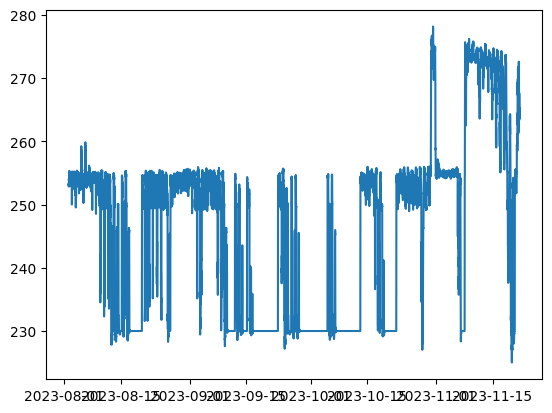

In [13]:
start = time.time()
predVal = predict(strangeData, LAGS[0], STEPS)
plt.plot(predVal, label="predizione Strange set")
end = time.time()
print(f"predizione sulo Strange set: {int(end-start)} s")

In [31]:
reg = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", XGBRegressor())
])

In [32]:
forecast = ForecasterAutoreg(reg, lags)

In [34]:
forecast.fit(trainingSet["Value"])

In [35]:
predVal = predict(validationSet, lags, STEPS)
printScore(allData.loc[predVal.index].values, predVal.values)

step 3741/3741

___SCORE___
mape: 0.0052383058596903774
r2: 0.9444069765579979


In [32]:
param_grid = {
    "reg__max_depth": [7,8,9,10],
    "reg__eta": [0.3, 0.1, 0.01],
    "reg__subsample": np.linspace(0,1,5),
    "reg__colsample_bytree": np.linspace(0,1,5)
}

In [33]:
lags_grid = [96, 192, 288]

In [ ]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = validationSet["Value"],
    param_grid  = param_grid,
    lags_grid   = lags_grid,
    steps       = 10,
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(validationSet)*0.8),
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)

Number of models compared: 1500.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:
res

In [40]:
a = np.linspace(0,99,100)
a

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [44]:
a[:-STEPS]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95.])

In [45]:
a[-STEPS:]

array([96., 97., 98., 99.])

In [41]:
trainingSet.index[int(len(trainingSet)*0.5)]

Timestamp('2023-04-03 02:15:00', freq='15T')

In [37]:
trainingSet.iloc[int(len(trainingSet)*0.5)]

Value    255.88
Name: 2023-04-03 02:15:00, dtype: float64

Text(2023-09-26 08:00:00, 50, '___SCORE___\nmape: 0.1\nr2: 0.1')

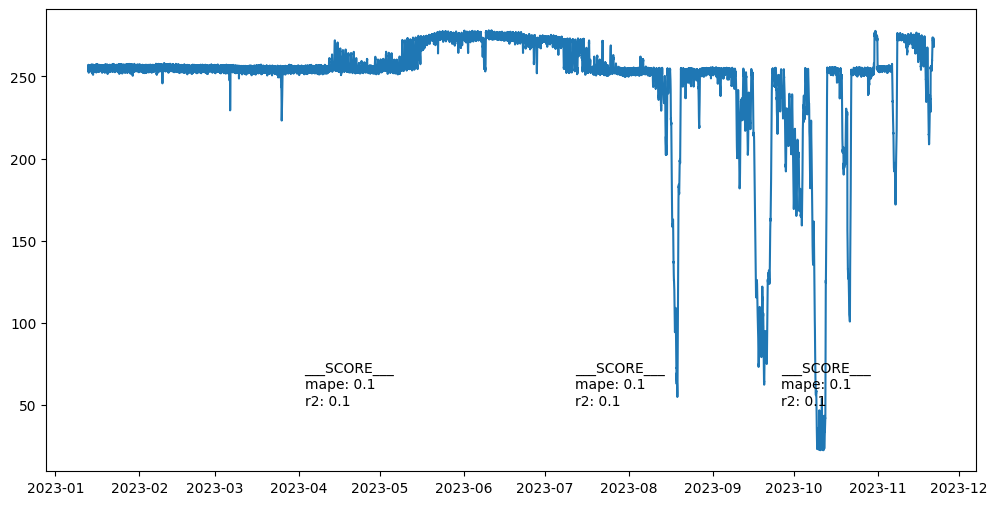

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
info = f"___SCORE___\nmape: 0.1\nr2: 0.1"
ax.plot(allData)
ax.annotate(info, (trainingSet.index[int(len(trainingSet)*0.5)],50))
ax.annotate(info, (validationSet.index[int(len(validationSet)*0.5)],50))
ax.annotate(info, (strangeData.index[int(len(strangeData)*0.5)],50))